# Prevendo a necessidade de internação para pacientes com COVID-19
![Alt](https://raw.githubusercontent.com/PedroHCAlmeida/Projeto_final_bootcamp/main/img/share.png?token=ASNXTHRK252ELJWBWQKPYETBB3TCG)

## Resumo

Após realizar o pré-processamento e a análise exploratória dos dados disponibilizados pelo Hospital Sírio-Libanês no [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), neste notebook o foco foi na solução do problema, ou seja, foram testados modelos de Machine Learning a fim de resolver o problema notificado pelo hospital com a melhor certeza nos resultados possível. Para isso foram testados 6 modelos diferentes de classificação, aplicando técnicas de reamostragem e de seleção de variáveis.

## Contexto do problema

O ano de 2020 começou de uma maneira completamente inesperada, o mundo foi atingido por uma das maiores crises sanitárias da história contemporânea, e uma palavra tomou conta das notícias nos jornais e mídias sociais brasileiras, **Leito**, a superlotação dos hopitais e a falta de leitos se tornou normal em todo o Brasil, nos anos de 2020 e 2021. Nesse contexto, o **objetivo** foi, a partir dos dados referente aos pacientes que sofreram da doença, criar um modelo capaz de prever se um paciente precisará de UTI nas **duas primeiras horas** que esse paciente é admitido no hospital.

# Escopo do notebook
- Importação dos pacotes 
- Importação das funções locais 
- Leitura dos dados preprocessados
- Métricas de avaliação
- Primeiros modelos
- Reamostragem
- Otimização
- Modelo final
- Resultados

# Importação dos pacotes

In [239]:
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import time
import warnings
import os

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from pipelinehelper import PipelineHelper
from joblib import dump
import pickle

In [240]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
SEED = 64541

# Importações das funções locais

In [3]:
os.chdir("../funcoes")
from my_classifier import Classifier
os.chdir("../notebooks")

# Leitura dos dados pré-processados

In [190]:
df = pd.read_csv('../dados/dados_preprocessados/preprocessados.csv')

In [6]:
sns.set_style('darkgrid')

In [7]:
df.head()

,AGE_ABOVE65,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_UNDER_30th,AGE_UNDER_50th,AGE_ABOVE_50th,AGE_ABOVE_80th
0,1,0,0,0,0,1,1,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,1,0,0


# Métricas de avaliação

A escolha das métricas para escolher o melhor modelo é uma escolha crucial para selecionar a melhor solução para o problema. No problema em questão, essas métricas devem ser muito bem escolhidas uma vez que estamos tratando de **dados reais relacionados a saúde**, e cada erro pode significar uma **vida**. Por esta razão, vou utilizar as seguintes métricas em todos os testes:

* ROC AUC
* F1 score
* Recall
* Precisão
* Acurácia

Todas as métricas serão utilizadas para acompanhar os resultados e não termos um modelo tendencioso, no entanto, as métricas que serão utilizadas para selecionar os modelos será, primeiramente, a ROC AUC para selecionar os dois melhores modelos sem nenhuma otimização, e, posteriormente, será realizada a otimização de hiperparâmetros com base na F1 score.

## ROC AUC

A métrica ROC AUC é utilizada para problemas de classificação binárias e consiste na área abaixo da curva ROC do modelo. Essa curva é gerada através das taxas de valores verdadeiros positivos e falsos positivos previstos pelo modelo. Ela consegue mensurar o quão bem um modelo consegue separar os dados em relação a variável alvo, no nosso caso, a capacidade de um modelo em separar, através de **probabilidades**, os pacientes que precisaram de cuidados intensivos dos pacientes que não precisaram de cuidados intensivos. Por esta razão, essa métrica vai ser utilizada para selecionar os dois melhores modelos que possuem a maior capacidade de separar esses dois grupos.  

![roc_curve](https://raw.githubusercontent.com/PedroHCAlmeida/Projeto_final_bootcamp/main/img/roc_curve.jpg?token=ASNXTHRPZWZSIUSKA57LS2LBB3SVG)

## F1 score

A métrica F1 score combina a precisão, que nos diz dos valores classificados quantos estavam corretos, e o recall, que nos diz dos valores corretos quantos foram calssificados corretamente. O principal fator que utilizarei essa métrica para realizar a otimização dos modelos é que ela sempre da um peso maior para o pior valor entre a precisão e o recall, ou seja, ela é mais sensível em modelos enviesados que possuem uma tendência maior de prever um determinados grupo. Com isso, tendo um maior valor dessa métrica teremos um maior equilíbrio entre as demais.

**OBS: FOI UTILIZADA A MÉDIA MACRO DA F1 SCORE PARA REALIZAR ESSA OTIMIZAÇÃO**

## Validação cruzada

Além de selecionar as métricas, devemos ter a maior certeza possível do resultado obtido pelo modelo, tentando excluir ao máximo a aleatoriedade na hora de testá-los. Para isso utilizarei uma **validação cruzada** em todos os testes.

A validação cruzada é um método estatístico usado para estimar a habilidade dos modelos de aprendizado de máquina, tem o objetivo de resumir a performance de um modelo de Machine Learning da maneira mais realista possível tentando generalizar ao máximo os testes. Essa técnica consiste em realizar divisões dentro do dataset inteiro gerando vários **subconjuntos** dos dados e, posteriormente, realizar treinamentos e testes alternando o subconjunto que será destinado aos testes (utilizando os demais para treino), e dessa forma calcular as métricas de diferentes combinações dos dados destinados para treino e teste. 

![CV](https://raw.githubusercontent.com/PedroHCAlmeida/Projeto_final_bootcamp/main/img/dataml_cross_validation.png?token=ASNXTHSHEXSDXFKCCL6AFZ3BB3SXK)

Porém realizar essa divisão de qualquer maneira pode criar um viés dependendo das proporções das classes da variável alvo em subconjunto, para isso podemos estabelecer um critério na hora dessa divisão, e o critério utilizado será tentar **manter a mesma proporção**, ou muito próximas, das classes 0 e 1(foi ou não foi para UTI) em **todos os subconjuntos**.<br>
Além disso, como foi visto na análise exploratória([notebooks/Analise_explotaroria](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/notebooks/Analise_exploratoria.ipynb)), o nosso dataset pré-processado possui informações de **294** pacientes, o que é um número pequeno de observações, e para tentar diminuir o efeito desse problema podemos realizar essa validação cruzada diversas vezes, e, a cada vez, dividir novamente o conjunto de dados em subconjuntos diferentes de forma aleatória. Para isso vou utilizar função RepeatedStratifiedKFold( ) do pacote sklearn.model_selection, que vai realizar a validação cruzada da seguinte maneira:
<br>
* 1 - Os dados serão embaralhados
* 2 - Os dados serão divididos em **5 subconjuntos** mantendo a mesma proporção da variável alvo("ICU")
* 3 - O processo será realizado **10 vezes**

Para realizar esse processo criei uma classe que irá repetir esses passos da mesma forma e com a mesma semente de números aleatórios, essa classe recebe o modelo e o conjunto de dados inteiro, embaralha esses dados de forma aleatória e separa em X(variáveis preditoras) e y(variáviel resposta). Essa classe possui uma função cross_val( ) para realizar essa validação calculando as métricas da seguinte forma:
* As métricas ROC AUC e Acurácia serão calculadas a cada treinamento e seus resultados serão salvos como atributo, além disso será calculado a média e o desvio padrão amostral construindo um intervalo de 95% para a média
* As métricas F1, precisão e recall serão calculadas da mesma maneira acima, porém serão utilizadas a média MACRO dessas métricas
* Serão calculadas as matrizes de confusão a cada treinamento, somando as, e, por fim será calculada a média dos elementos dessas matrizes
* Além disso serão calculadas as médias das métricas F1, precisão e recall para cada classe da variável alvo através da média das matrizes de confusão

Nessa classe foram definidas algumas funções para visualização dos resultados de forma mais fácil, abaixo segue o docstring inteiro da classe:

In [182]:
help(Classifier)

Help on class Classifier in module __main__:

class Classifier(builtins.object)
 |  Classifier(estimator, df: pandas.core.frame.DataFrame, SEED: int = 64541, target_variable='ICU', **estimator_args)
 |  
 |  Classe que recebe um modelo de machine learning, os dados que serão realizados os treinamentos e previsões, com isso embaralha esses dados e separa em um conjunto de dados para
 |  as variáveis preditoras(x) e a variável de resposta(y).Realiza uma validação cruzada através da função cross_val() e imprime seus resultados pela função report(), plota a curva roc
 |  pela função plot_roc_curve(), plota os histogramas das métricas calculadas pela função hist_metrics() e plota a média das matrizes de confusão pela função plot_confusion().
 |  
 |  Methods defined here:
 |  
 |  __init__(self, estimator, df: pandas.core.frame.DataFrame, SEED: int = 64541, target_variable='ICU', **estimator_args)
 |      Parâmetros Construtor:
 |      ---------------------
 |      estimator : modelo de mac

# Primeiros modelos

Ao se escolher o melhor modelo de Machine Learning precisamos ter um modelo de comparação para se ter um ponto de partida nas análises e comparações. Para isso precisamos de um modelo **"Baseline"**, um modelo mais simples que nos de uma referência do que é um resultado bom e do que é um resultado ruim. Para isso vou utilizar o modelo **DummyClassifier**, este modelo irá sempre chutar para os dados de treino a classe mais frequente no dataset de treino.<br><br>
Posteriormente serão testados os seguintes modelos de classificação:

|Modelo                 |Pacote              |Método
|:----------------------|:-------------------|-----------|
|LogisticRegression     |sklearn.linear_model|Regressão Logística
|DecisionTreeClassifier |sklearn.tree        |Árvore de decisão
|RandomForestClassifier |sklearn.ensemble    |Ensemble
|ExtraTreesClassifier   |sklearn.ensemble    |Ensemble
|XGBClassifier          |pacote xgboost      |Ensemble
|LGBMClassifier         |pacote lightgbm     |Ensemble

## Baseline

Vamos calcular agora as métricas que servirão de base de comparação. Como estarei utilizando o DummyClassifier( ) não precisaria de uma validação cruzada, já que ao dividir os subconjuntos usando o método "RepeatedStratifiedKFold" a proporção da classe de resposta será sempre a mesma, e, portanto, os valores previstos serão sempre os mesmos, no entanto utilizarei a classe Classifier( ) para tornar o processo automático e calcular todas as métricas de uma vez, além disso, como não é um modelo computacionalmente custoso não vejo problema.

In [278]:
dummy = Classifier(DummyClassifier, df, strategy='most_frequent')
dummy.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : DummyClassifier(random_state=64541, strategy='most_frequent')
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.500 ± 0.000   |  
ACCURACY  MÉDIA    : 0.643 ± 0.001   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.321 ± 0.000   |0.643     |nan    
RECALL MÉDIO       : 0.500 ± 0.000   |1.000     |0.000     
F1-SCORE  MÉDIO    : 0.391 ± 0.000   |0.783     |nan    

TEMPO MÉ

Agora que calculamos as métricas do modelo base, qualquer modelo que tiver uma média da curva **ROC AUC menor do que 0.5 será desconsiderado**.

OBS : No resultado das métricas do baseline nota-se que os resultados das médias para classe 1 foram valores nulos ou zero, isso é porque como a classe 0 é a mais frequente, ele preveu que ninguém ia para UTI em todos os casos, e com isso na hora de calcular as métricas houveram divisões por zero para o F1 score e precisão, e valor zero no numerador para o recall.

## LogisticRegression

In [279]:
lr = Classifier(LogisticRegression, df, max_iter=1000)
lr.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LogisticRegression(max_iter=1000, random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.746 ± 0.016   |  
ACCURACY  MÉDIA    : 0.697 ± 0.018   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.674 ± 0.023   |0.729     |0.605    
RECALL MÉDIO       : 0.639 ± 0.019   |0.842     |0.436     
F1-SCORE  MÉDIO    : 0.642 ± 0.020   |0.781     |0.507    

TEMPO MÉDIO 

Vemos que com uma regressão logística tivemos uma ROC AUC razoável, porém em relação às demais métricas parece que o modelo se deu bem melhor para prever dados da classe 0, correspondentes aos pacientes que não foram para UTI, do que da **classe 1**, onde tivemos um recall de apenas **0.436**, o que significa que o modelo está classificando muitas pessoas que **precisaram de UTI como se não fossem precisar**, o que é um erro **perigosíssimo**, uma vez que em uma situação real cada erro desses pode **significar uma vida**.

## DescisionTree

In [280]:
dt = Classifier(DecisionTreeClassifier, df)
dt.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : DecisionTreeClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.609 ± 0.017   |  
ACCURACY  MÉDIA    : 0.641 ± 0.016   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.612 ± 0.017   |0.720     |0.498    
RECALL MÉDIO       : 0.609 ± 0.017   |0.723     |0.494     
F1-SCORE  MÉDIO    : 0.608 ± 0.017   |0.721     |0.496    

TEMPO MÉDIO DE TREINAME

O modelo DescisionTreeClassifier se saiu pior ainda do que a regressão logística, e apresentou os mesmos padrões, em que teve muita dificuldade de prever dados da **classe 1**, e dessa vez obteve todas as métricas dessa classe **abaixo de 0.5**.

## RandomForestClassifier

In [281]:
rf = Classifier(RandomForestClassifier, df)
rf.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : RandomForestClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.763 ± 0.015   |  
ACCURACY  MÉDIA    : 0.705 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.684 ± 0.019   |0.734     |0.622    
RECALL MÉDIO       : 0.648 ± 0.015   |0.849     |0.447     
F1-SCORE  MÉDIO    : 0.652 ± 0.017   |0.788     |0.520    

TEMPO MÉDIO DE TREINAME

No modelo RandomForestClassifier se obteve uma pequena melhora na ROC AUC, porém ainda existe **muita dificuldade ao prever se o paciente precisará ir para UTI**, com um recall de 0.447 para esta classe.

## ExtraTreesClassifier

In [282]:
et = Classifier(ExtraTreesClassifier, df)
et.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : ExtraTreesClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.724 ± 0.019   |  
ACCURACY  MÉDIA    : 0.667 ± 0.016   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.634 ± 0.023   |0.703     |0.551    
RECALL MÉDIO       : 0.600 ± 0.017   |0.834     |0.366     
F1-SCORE  MÉDIO    : 0.600 ± 0.019   |0.763     |0.440    

TEMPO MÉDIO DE TREINAMENT

Com o modelo ExtraTreesClassifier mais uma vez o mesmo problema para prever a **classe 1**, dessa vez com o pior recall até agora de **0.366**.

## XGBClassifier

In [283]:
xg = Classifier(XGBClassifier, df, verbosity=0)
xg.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=64541, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-----------------------------------

Agora com o modelo XGBClassifier() fica evidente, mais uma vez, que, independente do modelo testado, estamos tendo um problema enorme em previsões da **classe 1**.

## LGBMClassifier

In [284]:
lgbm = Classifier(LGBMClassifier, df, verbosity=-1)
lgbm.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LGBMClassifier(random_state=64541, verbosity=-1)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.758 ± 0.013   |  
ACCURACY  MÉDIA    : 0.716 ± 0.013   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.693 ± 0.016   |0.755     |0.623    
RECALL MÉDIO       : 0.672 ± 0.015   |0.825     |0.519     
F1-SCORE  MÉDIO    : 0.676 ± 0.015   |0.789     |0.566    

TEMPO MÉDIO DE TR

Por fim o último modelo, LGBMClassifier, apresentou os mesmos problemas encontrados em todos os 6. Vamos observar a **curva ROC** para ver como que os modelos estão performando na hora de **diferenciar as classes**. 

## Curva ROC dos modelos

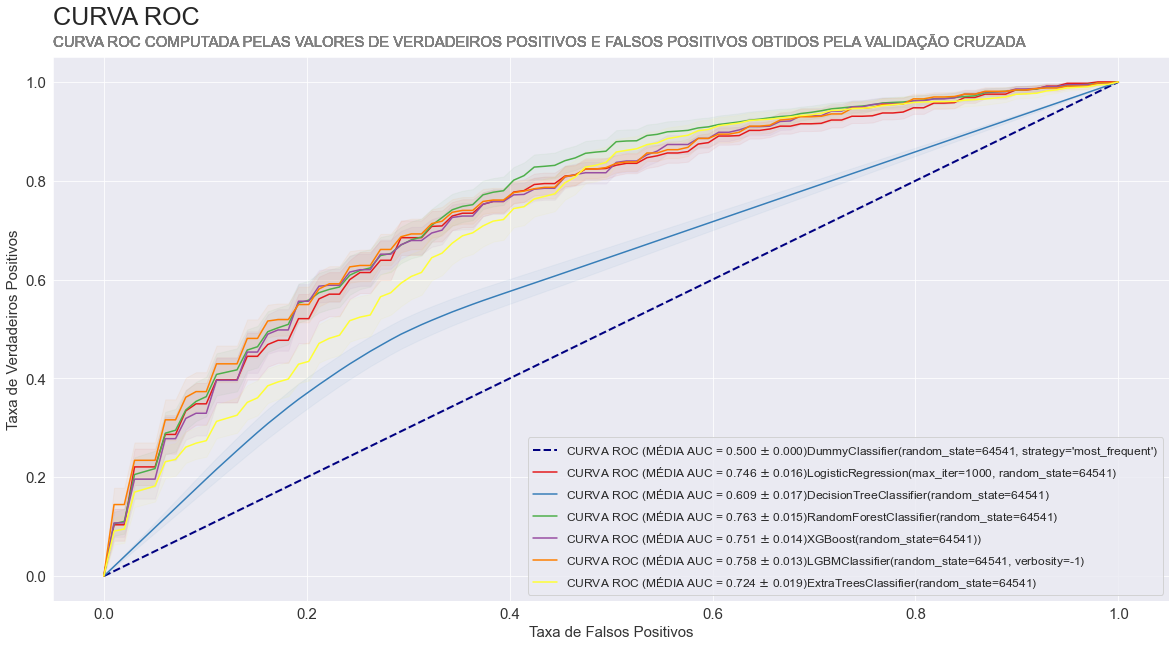

In [285]:
sns.set_palette(sns.color_palette('Set1'), 6)
ax = dummy.plot_roc_curve(color='navy', lw=2, linestyle='--')
lr.plot_roc_curve(ax=ax)
dt.plot_roc_curve(ax=ax)
rf.plot_roc_curve(ax=ax)
xg.plot_roc_curve(ax=ax, name_estimator='XGBoost(random_state=64541))')
lgbm.plot_roc_curve(ax=ax)
et.plot_roc_curve(ax=ax)
plt.show()

A partir da curva ROC fica claro que os modelos estão performando mal, mesmo com alguns com uma área abaixo da curva razoável, as curvas se apresentam muito achatadas, principalmente a DecisionTreeClassifier.Para resolver esse problema precisamos entender como surge esse problema, sabemos que os modelos estão com uma **facilidade maior** em prever a **classe 0**, o que pode ser um forte indício de um viés por parte desses modelos, e como foi visto no gráfico 1 da [Análise exploratória de dados](https://github.com/PedroHCAlmeida/Projeto_final_bootcamp/blob/main/notebooks/Analise_exploratoria.ipynb), o nosso dataset possui um **desbalanceamento** em relação as classes da variável alvo, **será que isso pode estar causando um viés no modelo?**.<br>
Para responder essa pergunta vamos aplicar alguma técnica para balancear esses dados e descobrir se esse pode ser o motivo do desempenho ruim dos modelos.

# Reamostragem

Como foi mencionado, no dataset pré-processado temos mais dados de pacientes que não preciram ir para UTI do que dados pacientes que precisaram desses cuidados intensivos. Esse pode ser um fator para os primeiros modelos não estarem conseguindo separar esses dois grupos tão bem.<br><br>
Para resolver este problema temos algumas opções, a melhor delas seria coletar novos dados, no entanto essa opção não é viável nesse caso, uma vez que não temos acessos a essa coleta. Outras opções que poderíamos experimentar seria o **"undersampling"**, que seria eliminar dados da classe **majoritária** até termos uma dataset balanceado, e **"oversampling"**, que seria realizar uma reamostragem, de forma **aleatória**, utilizando **dados existentes** da classe **minoritária** e duplicando-os até as classes estiverem balanceadas.<br><br>
Nesse caso, como nós temos em mão poucas observações, apenas **294**, acredito que a técnica de **"oversampling"** pode ser melhor, uma vez que se eliminarmos dados existentes estaríamos diminuindo o dataset ainda mais.

![](../img/reamostragem.png)

In [84]:
df['ICU'].value_counts()

0    189
1    105
Name: ICU, dtype: int64

Verificando o dataset novamente, temos que 189 pacientes pertencem a classe 0(não foi para UTI) e 105 pacientes pertencem a classe 1(foram para UTI).Para realizar este "oversampling", primeiramente, vou dividir os dados de acordo com a classe(0 ou 1) em dois dataframes separados.

In [85]:
#Dividindo os dados com base na variável "ICU"
icu0 = df.query('ICU == 0')
icu1 = df.query('ICU == 1')

Como a nossa classe minoritária é a classe 1, vou utilizar a função resample do pacote sklearn.utils para realizar essa reamostragem utilizando apenas o dataframe correspondente aos pacientes que foram para UTI(icu1).

In [86]:
#Passando o dataframe com a classe minoritária, o tamanho da classe majoritária para o parâmetro n_samples, e o parâmetro random_state=SEED,
#para definir a semente aleatória e garantir a reprodutibilidade
icu1_resample = resample(icu1,
                         n_samples=len(icu0),
                         random_state=SEED)

In [202]:
len(icu1_resample)

189

Verificando o tamanho dessa reamostragem temos os dataframes das duas classes com o mesmo tamanho, e vamos juntá-los em apenas um dataframe novamente.

In [191]:
#Juntando as duas classes no df_resample
df_resample = pd.concat([icu1_resample, icu0], axis=0)
df_resample['ICU'].value_counts()

1    189
0    189
Name: ICU, dtype: int64

Agora percebemos que temos um dataframe balanceado em relação a variável alvo, com isso, vamos utilizar os mesmos modelos e realizar as validações cruzadas novamente.

## LogisticRegression

In [248]:
lr_resample = Classifier(LogisticRegression, df_resample, max_iter=1000)
lr_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LogisticRegression(max_iter=1000, random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.780 ± 0.013   |  
ACCURACY  MÉDIA    : 0.726 ± 0.014   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.729 ± 0.014   |0.720     |0.733    
RECALL MÉDIO       : 0.726 ± 0.014   |0.741     |0.712     
F1-SCORE  MÉDIO    : 0.725 ± 0.014   |0.730     |0.722    

TEMPO MÉDIO 

## DecisionTree

In [249]:
dt_resample = Classifier(DecisionTreeClassifier, df_resample)
dt_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : DecisionTreeClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.793 ± 0.010   |  
ACCURACY  MÉDIA    : 0.793 ± 0.010   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.804 ± 0.010   |0.853     |0.750    
RECALL MÉDIO       : 0.793 ± 0.010   |0.707     |0.878     
F1-SCORE  MÉDIO    : 0.791 ± 0.011   |0.774     |0.809    

TEMPO MÉDIO DE TREINAME

## RandomForest

In [250]:
rf_resample = Classifier(RandomForestClassifier, df_resample)
rf_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : RandomForestClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.945 ± 0.007   |  
ACCURACY  MÉDIA    : 0.863 ± 0.011   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.866 ± 0.011   |0.885     |0.843    
RECALL MÉDIO       : 0.863 ± 0.011   |0.834     |0.892     
F1-SCORE  MÉDIO    : 0.863 ± 0.011   |0.859     |0.867    

TEMPO MÉDIO DE TREINAME

## ExtraTrees

In [251]:
et_resample = Classifier(ExtraTreesClassifier, df_resample)
et_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : ExtraTreesClassifier(random_state=64541)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.942 ± 0.007   |  
ACCURACY  MÉDIA    : 0.869 ± 0.011   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.872 ± 0.011   |0.858     |0.882    
RECALL MÉDIO       : 0.869 ± 0.011   |0.886     |0.853     
F1-SCORE  MÉDIO    : 0.869 ± 0.011   |0.871     |0.867    

TEMPO MÉDIO DE TREINAMENT

## XGBoost

In [252]:
xg_resample = Classifier(XGBClassifier, df_resample, verbosity=0)
xg_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=64541, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-----------------------------------

## LGBM

In [253]:
lgbm_resample = Classifier(LGBMClassifier, df_resample, verbosity=-1)
lgbm_resample.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : LGBMClassifier(random_state=64541, verbosity=-1)
----------------------------------------------------------------------------------
Métricas no dataset de teste:           
Intervalo de 95% da média            |   Média por classe
-------------------------------------|--------------------------------------------
ROC AUC MÉDIA      : 0.939 ± 0.008   |  
ACCURACY  MÉDIA    : 0.860 ± 0.010   |
-------------------------------------|--------------------------------------------
                      MÉDIA MACRO    |CLASSE 0  |CLASSE 1
----------------------------------------------------------------------------------
PRECISÃO  MÉDIA    : 0.864 ± 0.010   |0.889     |0.835    
RECALL MÉDIO       : 0.860 ± 0.010   |0.823     |0.897     
F1-SCORE  MÉDIO    : 0.860 ± 0.010   |0.855     |0.865    

TEMPO MÉDIO DE TR

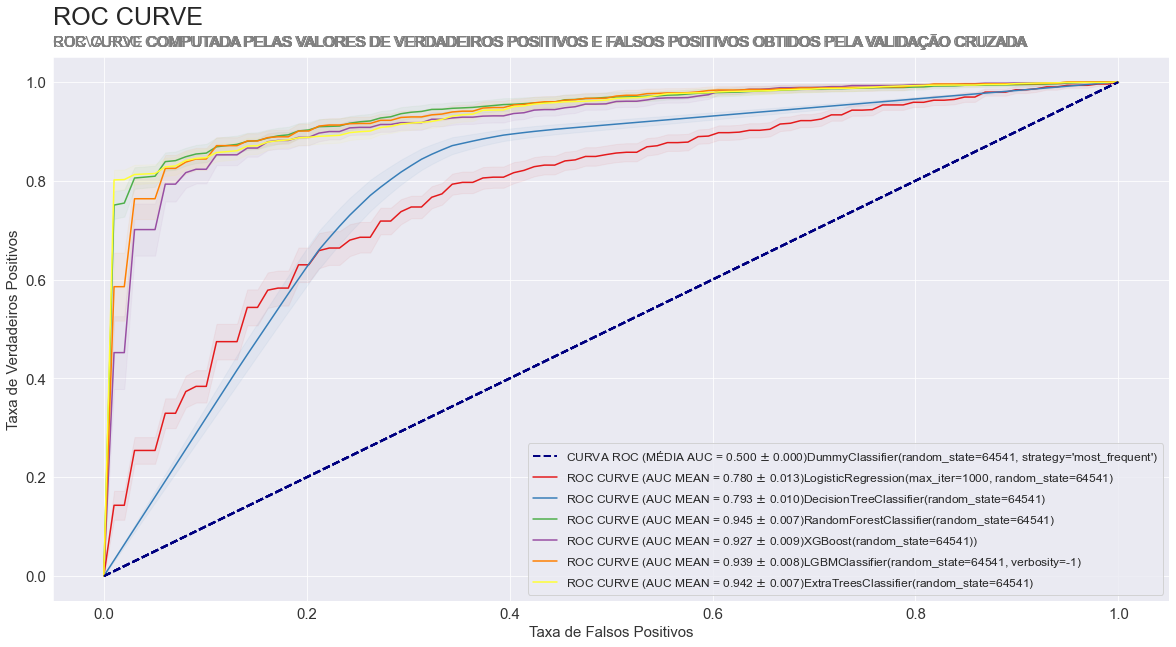

In [287]:
sns.set_palette(sns.color_palette('Set1'), 6)
ax = dummy.plot_roc_curve(color='navy', lw=2, linestyle='--')
lr_resample.plot_roc_curve(ax=ax)
dt_resample.plot_roc_curve(ax=ax)
rf_resample.plot_roc_curve(ax=ax)
xg_resample.plot_roc_curve(ax=ax, name_estimator='XGBoost(random_state=64541))')
lgbm_resample.plot_roc_curve(ax=ax)
et_resample.plot_roc_curve(ax=ax)
plt.show()

# Otimização

In [288]:
#Embaralhando o dataframe da mesma maneira que foi realizada a validação cruzada utilizando a classe Classifier() para reproduzir os resultados
df_resample_shuffle = df_resample.sample(frac=1, random_state=SEED).reset_index(drop=True)

#Utilizando o mesmo método com os mesmos valores que foi realizada a validação cruzada utilizando a classe Classifier() para reproduzir os resultados
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED)

#Separando os dados em X e y para realizar a otimização dos parâmetros
X = df_resample_shuffle.drop('ICU', axis=1)
y = df_resample_shuffle['ICU']

In [ ]:
pipe = Pipeline([
    ('feature_selection', PipelineHelper([
        ('rf',  SelectFromModel(RandomForestClassifier()))])),
    ('classifier', PipelineHelper([
        ('rf', RandomForestClassifier()),
        ('et', ExtraTreesClassifier())
    ])),
])

params = {
    'feature_selection__selected_model': pipe.named_steps['feature_selection'].generate({
        'rf__threshold': [0,  'median', 'mean', '1.25*mean'],
        'rf__estimator__random_state':[SEED]
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'rf__bootstrap':[True, False],
        'rf__max_depth': [None, 5, 10, 15,20],
        'rf__max_features' : [4, 'auto', 10],
        'rf__random_state' : [SEED],
        'rf__n_estimators': [100, 200, 400, 800],
        'rf__min_samples_split': [2, 3, 5],
        'rf__min_samples_leaf': [1, 2, 3],
        'et__bootstrap':[True, False],
        'et__random_state' : [SEED],
        'et__max_depth': [None, 5, 10, 15, 20],
        'et__n_estimators': [100, 200, 400, 800],
        'et__max_features' : [4, 'auto', 10],
        'et__min_samples_split': [2, 3, 5],
        'et__min_samples_leaf': [1, 2, 3]
    })
}
random_search = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=cv, n_iter=100, scoring='f1_macro', verbose=1, random_state=SEED)
start = time.time()
random_search.fit(X,y)
end=time.time()
print(f'Os parâmetros do modelo com o melhor resultado foi {random_search.best_params_}')
print(f'O melhor resultado para a média da f1 score foi de {random_search.best_score_}')
print(f'O melhor modelo foi {random_search.best_estimator_}')
print(f'O tempo para essa procura foi de {(end-start)/60} minutos')

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


In [215]:
with open('../arquivos_modelo/SearchCV_salvo/random_searchcv', 'wb') as random_search_file:
    pickle.dump(random_search, random_search_file) 

# Modelo Final

In [200]:
best = Classifier(random_search.best_estimator_, df_resample)
best.cross_val()

  0%|          | 0/50 [00:00<?, ?it/s]

10 repetições de Validação Cruzada com 5 divisões no dataset
----------------------------------------------------------------------------------
CLASSIFICADOR                           : Pipeline(steps=[('feature_selection',
                 PipelineHelper(available_models={'rf': SelectFromModel(estimator=RandomForestClassifier(random_state=64541),
                                                                        threshold='1.25*mean')},
                                selected_model=SelectFromModel(estimator=RandomForestClassifier(random_state=64541),
                                                               threshold='1.25*mean'))),
                ('classifier',
                 PipelineHelper(available_models={'et': ExtraTreesClassifier(max_features=4,
                                                                             min_samples_split=5,
                                                                             random_state=64541),
                           

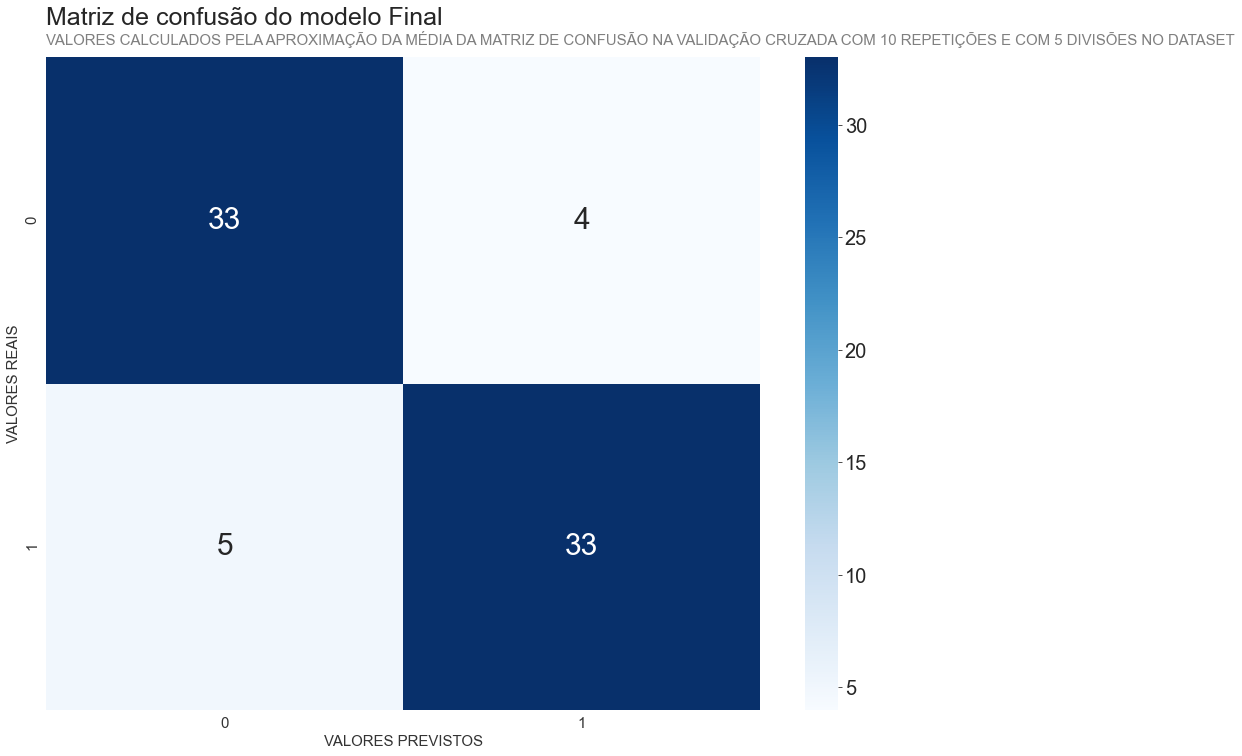

In [207]:
best.plot_confusion(name_estimator='Final')
plt.show()

A fim de se obter a maior certeza nesses resultados e, testar se essa validação cruzada com 10 divisões e 5 repetições é a ideal vou testar a hipótese nula que as métricas obtidas seguem uma distribuição normal, e com isso, podemos definir, de forma confirmatória, o intervalo de confiança para média de cada métrica igual a:

## $$\mu = \bar{x} \pm \frac{\sigma}{\sqrt{n}}$$

#### Onde $\mu$ é a média populacional, $\bar{x}$ é a média da amostra das métricas calculadas, $\sigma$ é o desvio padrão amostral calculado e n é o tamanho da amostra, que no nosso caso é 50, 5 repetiçoes e 10 divisões do dataset $5\:X\:10 = 50$

Primeiramente vou observar essas métricas por meio de um histograma a fim de entender suas distribuições.

for metric,value in be.scores.items():
    _, p_value = normaltest(value)
    print(metric,p_value)

# Resultados